# STEP 3

In [7]:
import os
import polars as pl
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
import copy

In [12]:
# 1. Load Training Data
train_path = "/content/train.csv"
df_train = pl.read_csv(train_path)
print(df_train.head())

shape: (5, 98)
┌─────────┬─────┬─────┬─────┬───┬──────┬─────────────────┬────────────────┬────────────────────────┐
│ date_id ┆ D1  ┆ D2  ┆ D3  ┆ … ┆ V9   ┆ forward_returns ┆ risk_free_rate ┆ market_forward_excess_ │
│ ---     ┆ --- ┆ --- ┆ --- ┆   ┆ ---  ┆ ---             ┆ ---            ┆ returns                │
│ i64     ┆ i64 ┆ i64 ┆ i64 ┆   ┆ str  ┆ f64             ┆ f64            ┆ ---                    │
│         ┆     ┆     ┆     ┆   ┆      ┆                 ┆                ┆ f64                    │
╞═════════╪═════╪═════╪═════╪═══╪══════╪═════════════════╪════════════════╪════════════════════════╡
│ 0       ┆ 0   ┆ 0   ┆ 0   ┆ … ┆ null ┆ -0.002421       ┆ 0.000301       ┆ -0.003038              │
│ 1       ┆ 0   ┆ 0   ┆ 0   ┆ … ┆ null ┆ -0.008495       ┆ 0.000303       ┆ -0.009114              │
│ 2       ┆ 0   ┆ 0   ┆ 0   ┆ … ┆ null ┆ -0.009624       ┆ 0.000301       ┆ -0.010243              │
│ 3       ┆ 0   ┆ 0   ┆ 0   ┆ … ┆ null ┆ 0.004662        ┆ 0.000299       ┆ 

In [14]:
pdf = df_train.to_pandas()

# price proxy
pdf["price_proxy"] = (1 + pdf["forward_returns"]).cumprod()

# 1. price momentum
for w in [5, 21, 63]:
    pdf[f"ret_{w}d_mom"] = pdf["forward_returns"].rolling(w).sum()

# 2. Moving averages
for w in [5, 21, 63]:
    ma_col = f"ma_{w}"
    pdf[ma_col] = pdf["price_proxy"].rolling(w).mean()
    pdf[f"price_over_ma_{w}"] = pdf["price_proxy"] / pdf[ma_col]

# 3. Rolling volatility
for w in [21, 63]:
    pdf[f"vol_{w}d"] = pdf["forward_returns"].rolling(w).std()

# drawdown proxy (recent w days cum of returns)
for w in [21, 63]:
    roll_cum = pdf["forward_returns"].rolling(w).sum()
    roll_max = roll_cum.rolling(w).max()
    pdf[f"dd_{w}d"] = roll_cum - roll_max

df_train = pl.from_pandas(pdf)

In [15]:
# === new feature ===
print("=== New Feature List ===")
new_features = [
    'price_proxy',
    'ret_5d_mom', 'ret_21d_mom', 'ret_63d_mom',
    'ma_5', 'ma_21', 'ma_63',
    'price_over_ma_5', 'price_over_ma_21', 'price_over_ma_63',
    'vol_21d', 'vol_63d',
    'dd_21d', 'dd_63d'
]

for feat in new_features:
    if feat in pdf.columns:
        print(f"✓ {feat}: {pdf[feat].notna().sum()} non-null values")
        print(f"  - mean: {pdf[feat].mean():.6f}, std: {pdf[feat].std():.6f}")
        print(f"  - NaN: {pdf[feat].isna().sum()}")
    else:
        print(f"✗ {feat}: NOT FOUND")

sample_cols = ['date_id', 'forward_returns'] + new_features[:4]
print(pdf[sample_cols].head())


=== New Feature List ===
✓ price_proxy: 9021 non-null values
  - mean: 9.179578, std: 9.388705
  - NaN: 0
✓ ret_5d_mom: 9017 non-null values
  - mean: 0.002356, std: 0.022219
  - NaN: 4
✓ ret_21d_mom: 9001 non-null values
  - mean: 0.009993, std: 0.042477
  - NaN: 20
✓ ret_63d_mom: 8959 non-null values
  - mean: 0.030031, std: 0.069394
  - NaN: 62
✓ ma_5: 9017 non-null values
  - mean: 9.174075, std: 9.376415
  - NaN: 4
✓ ma_21: 9001 non-null values
  - mean: 9.152620, std: 9.329583
  - NaN: 20
✓ ma_63: 8959 non-null values
  - mean: 9.097246, std: 9.208855
  - NaN: 62
✓ price_over_ma_5: 9017 non-null values
  - mean: 1.000853, std: 0.011100
  - NaN: 4
✓ price_over_ma_21: 9001 non-null values
  - mean: 1.004358, std: 0.023927
  - NaN: 20
✓ price_over_ma_63: 8959 non-null values
  - mean: 1.013536, std: 0.040694
  - NaN: 62
✓ vol_21d: 9001 non-null values
  - mean: 0.009491, std: 0.004724
  - NaN: 20
✓ vol_63d: 8959 non-null values
  - mean: 0.009708, std: 0.004207
  - NaN: 62
✓ dd_21d:

In [16]:
# 2. Preprocessing
# Exclude non-feature columns
ignore_cols = ['date_id', 'forward_returns', 'market_forward_excess_returns', 'risk_free_rate']
feature_cols = [c for c in df_train.columns if c not in ignore_cols]
target_col = 'market_forward_excess_returns'

# Convert to Pandas for CatBoost
X = df_train.select(feature_cols).to_pandas()
y = df_train.select(target_col).to_pandas().values.ravel()

# Convert any non-numeric objects to NaN.
X = X.apply(pd.to_numeric, errors='coerce')

# Identify columns that are entirely NaN and drop them before imputation
all_nan_cols = X.columns[X.isnull().all()].tolist()
X = X.drop(columns=all_nan_cols)

# Fill NaN with mean value by using SimpleImputer
imputer = SimpleImputer(strategy='mean')
X_imputed_array = imputer.fit_transform(X)
X = pd.DataFrame(X_imputed_array, columns=X.columns)

# Prepare data for volatility initialization (Last 60 days of returns)
train_returns = df_train.select('forward_returns').tail(60).to_numpy().flatten()

In [24]:
# 3. Time-Series Cross-Validation (Validation ONLY)
tscv = TimeSeriesSplit(n_splits=5)
cv_scores = []

model_name = "CatBoost"
model_instance = CatBoostRegressor(
        iterations=600, learning_rate=0.03, depth=6,
        loss_function='RMSE', verbose=False, allow_writing_files=False, random_seed=42
    )

results = {}      # Store CV scores for each model
best_score = float('inf') # Initial value for finding minimum MSE
best_model_name = ""
best_model_instance = None

print("Starting Time-Series Cross-Validation (Comparing Models)...")
print("-" * 50)

# Loop through each model to perform CV
cv_scores = []

for fold, (train_index, val_index) in enumerate(tscv.split(X)):
    X_train_cv, X_val_cv = X.iloc[train_index], X.iloc[val_index]
    y_train_cv, y_val_cv = y[train_index], y[val_index]

    # Initialize model
    current_model = CatBoostRegressor(
    iterations=600, learning_rate=0.03, depth=6,
    loss_function='RMSE', verbose=False, allow_writing_files=False, random_seed=42)

    current_model.fit(X_train_cv, y_train_cv)

    preds = current_model.predict(X_val_cv)
    mse = mean_squared_error(y_val_cv, preds)
    cv_scores.append(mse)

    print(f"    Fold {fold+1} MSE: {mse:.6f}")

    # Calculate average MSE
    avg_mse = np.mean(cv_scores)
    results[model_name] = avg_mse
    print(f"  -> {model_name} Average CV MSE: {avg_mse:.6f}")

    # Update the best performing model (Lower MSE is better)
    if avg_mse < best_score:
        best_score = avg_mse
        best_model_name = model_name
        # Save the instance to retrain on full data later
        best_model_instance = model_instance

print("-" * 50)
print(f"🏆 Best Model: {best_model_name} (MSE: {best_score:.6f})")

Starting Time-Series Cross-Validation (Comparing Models)...
--------------------------------------------------
    Fold 1 MSE: 0.000069
  -> CatBoost Average CV MSE: 0.000069
    Fold 2 MSE: 0.000021
  -> CatBoost Average CV MSE: 0.000045
    Fold 3 MSE: 0.000033
  -> CatBoost Average CV MSE: 0.000041
    Fold 4 MSE: 0.000012
  -> CatBoost Average CV MSE: 0.000034
    Fold 5 MSE: 0.000023
  -> CatBoost Average CV MSE: 0.000032
--------------------------------------------------
🏆 Best Model: CatBoost (MSE: 0.000032)


In [25]:
# Final Model Training
final_model = CatBoostRegressor(**best_model_instance.get_params())


final_model.fit(X, y)
print("Final model training completed.")

importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False)

# Top 20
print(importance_df.head(20))

Final model training completed.
              feature  importance
99    price_over_ma_5   57.565952
50                 M4   14.447460
66                 P7   10.743430
101  price_over_ma_21    1.816644
104           vol_21d    1.592576
48                 M2    1.470525
85                V13    1.302393
19                E19    0.884229
95         ret_5d_mom    0.755318
103  price_over_ma_63    0.510845
91                 V7    0.488947
76                 S5    0.379152
106            dd_21d    0.361791
64                 P5    0.344640
79                 S8    0.341208
96        ret_21d_mom    0.305936
57                P10    0.265394
97        ret_63d_mom    0.254180
94        price_proxy    0.230124
107            dd_63d    0.216826


In [26]:
# 5. Volatility Management Class
class VolatilityController:
    def __init__(self, window_size=60, target_ratio=1.15, initial_returns=None):
        self.window_size = window_size
        self.target_ratio = target_ratio
        self.history = []

        # Initialize buffer with the end of training data
        if initial_returns is not None:
            for ret in initial_returns:
                self.history.append({'market_ret': ret, 'weight': 1.0})

    def calculate_safe_weight(self, raw_weight, current_lagged_return, last_weight):
        # Update history with realized return from the previous step
        if current_lagged_return is not None:
             self.history.append({'market_ret': current_lagged_return, 'weight': last_weight})

        # Maintain window size
        if len(self.history) > self.window_size:
            self.history.pop(0)

        # Warm-up check
        if len(self.history) < 10:
            return raw_weight

        # Calculate Volatility Ratio
        market_rets = np.array([x['market_ret'] for x in self.history])
        weights = np.array([x['weight'] for x in self.history])
        strategy_rets = weights * market_rets

        vol_bench = np.std(market_rets)
        vol_strat = np.std(strategy_rets)

        if vol_bench < 1e-7:
            return raw_weight

        current_ratio = vol_strat / vol_bench

        # Apply scaling if ratio exceeds target (1.15 to be safe for 1.20 limit)
        scaling_factor = 1.0
        if current_ratio > self.target_ratio:
            scaling_factor = self.target_ratio / current_ratio

        return raw_weight * scaling_factor

# Step 4

In [33]:
def calculate_local_sharpe(returns, risk_free_rate=0.0):
    """Local Sharpe-variant score"""
    excess_returns = returns - risk_free_rate
    mean_ret = np.mean(excess_returns)
    std_ret = np.std(excess_returns)
    if std_ret == 0:
        return 0.0
    sharpe = mean_ret / std_ret
    #
    return sharpe

# CV fold
tscv = TimeSeriesSplit(n_splits=5)
cv_sharpe_scores = [] # Renamed from 'scores' to avoid confusion and better reflect content

scalefactor = 5000.0

for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    fold_model = type(final_model)(**final_model.get_params())
    fold_model.fit(X_train, y_train)

    # predict
    pred_excess = fold_model.predict(X_val)
    sigmoid_val = 1 / (1 + np.exp(-pred_excess * scalefactor))
    raw_weights = 2.0 * sigmoid_val

    # Volatility controller
    vol_manager = VolatilityController(initial_returns=train_returns)

    weights = []
    last_weight = 1.0
    for i, rw in enumerate(raw_weights):
        lagged_ret = y_val[i-1] if i > 0 else None
        w = vol_manager.calculate_safe_weight(rw, lagged_ret, last_weight)
        weights.append(max(0.0, min(2.0, w)))
        last_weight = w

    strategy_returns = np.array(weights) * y_val

    # Local Sharpe-variant score
    score = calculate_local_sharpe(strategy_returns)
    cv_sharpe_scores.append(score)
    print(f"Fold {fold+1} Local Sharpe-variant: {score:.4f}")

# Avarage
print(f"Average Local Sharpe-variant: {np.mean(cv_sharpe_scores):.4f}")

Fold 1 Local Sharpe-variant: 0.4880
Fold 2 Local Sharpe-variant: 0.5109
Fold 3 Local Sharpe-variant: 0.5360
Fold 4 Local Sharpe-variant: 0.5450
Fold 5 Local Sharpe-variant: 0.5540
Average Local Sharpe-variant: 0.5268


In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit

def backtest_full_pipeline(X, y, final_model, vol_manager=None):
    """backtesting"""
    tscv = TimeSeriesSplit(n_splits=5)

    all_strategy_returns = []
    all_benchmark_returns = []
    all_vol_ratios = []

    for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        # fold model
        fold_model = type(final_model)(**final_model.get_params())
        fold_model.fit(X_train, y_train)

        pred_excess = fold_model.predict(X_val)
        scalefactor = 5000.0
        sigmoid_val = 1 / (1 + np.exp(-pred_excess * scalefactor))
        raw_weights = 2.0 * sigmoid_val

        # Volatility
        if vol_manager:
            weights = []
            last_weight = 1.0
            for i, rw in enumerate(raw_weights):
                lagged_ret = y_val[i-1] if i > 0 else None
                w = vol_manager.calculate_safe_weight(rw, lagged_ret, last_weight)
                weights.append(max(0.0, min(2.0, w)))
                last_weight = w
        else:
            weights = np.clip(raw_weights, 0.0, 2.0)

        # Strategy returns
        strategy_rets = weights * y_val
        benchmark_rets = y_val  # S&P 500 buy-and-hold

        all_strategy_returns.extend(strategy_rets)
        all_benchmark_returns.extend(benchmark_rets)

        # Volatility ratio
        vol_strategy = np.std(strategy_rets)
        vol_benchmark = np.std(benchmark_rets)
        vol_ratio = vol_strategy / vol_benchmark if vol_benchmark > 0 else 0
        all_vol_ratios.append(vol_ratio)

    return np.array(all_strategy_returns), np.array(all_benchmark_returns), np.array(all_vol_ratios)


=== Step 4: Evaluation & Backtesting ===
Strategy Modified Sharpe: 0.5159
Benchmark Sharpe: 0.0059
Volatility Ratio (avg): 1.189 (limit: ≤1.20)


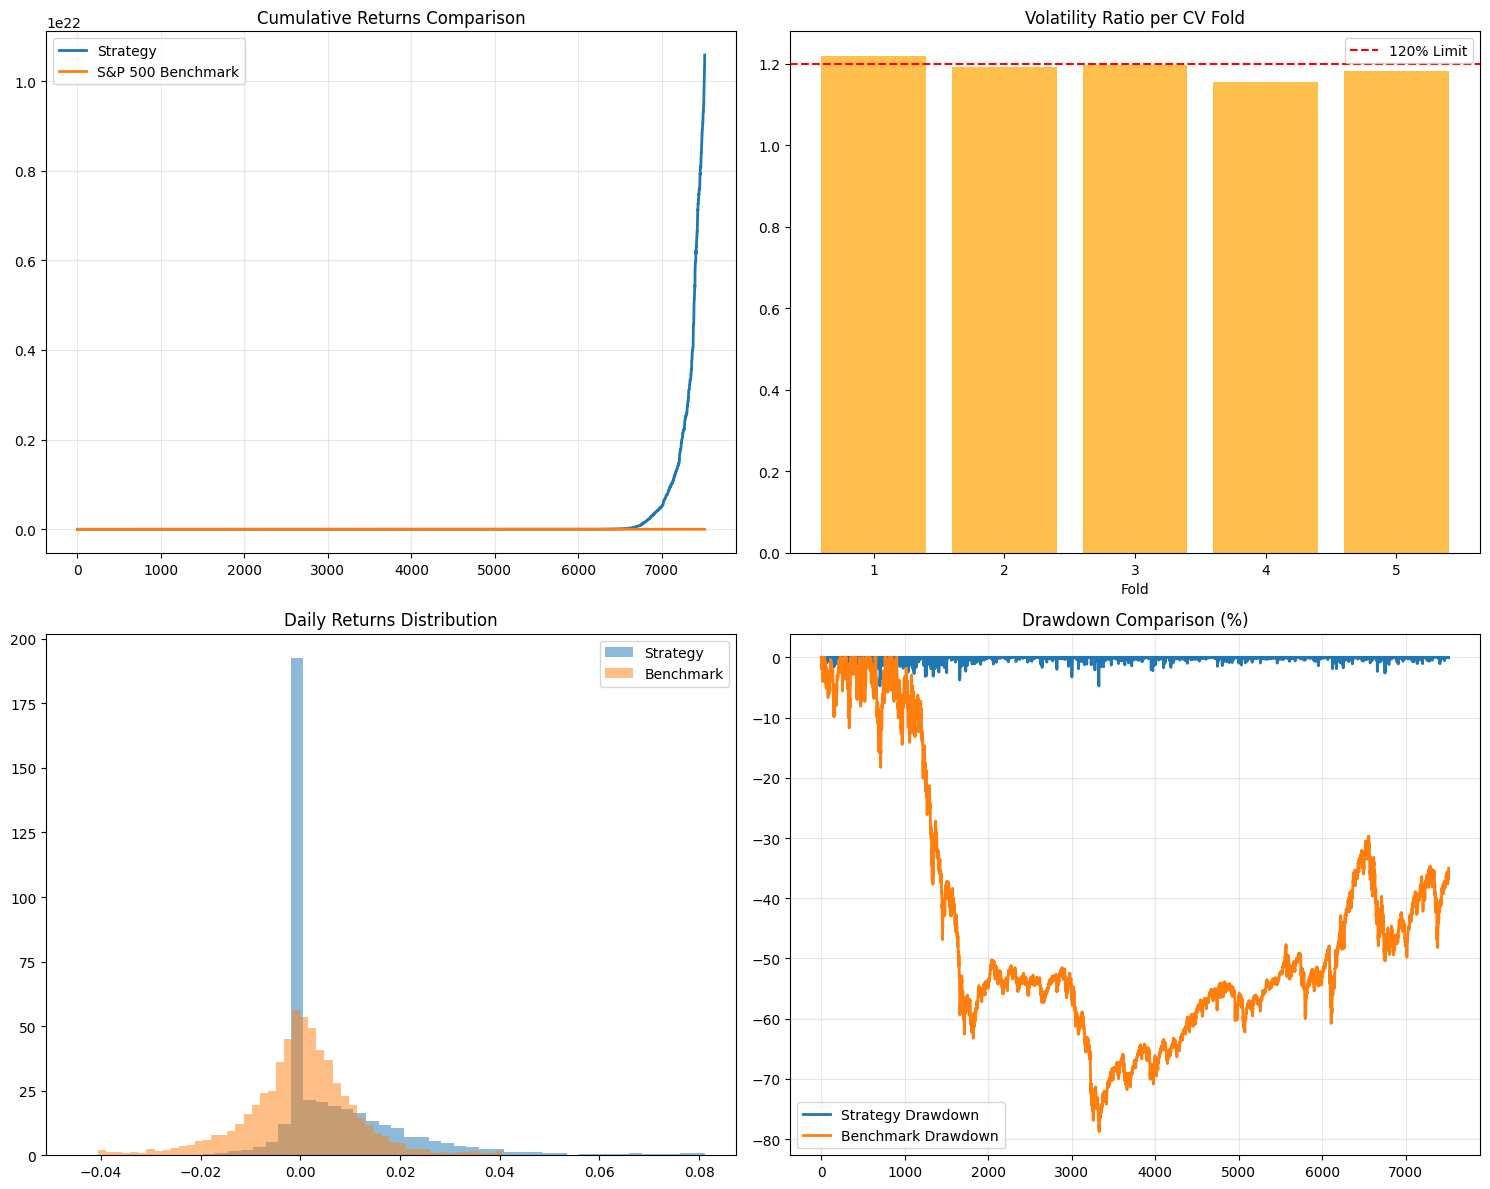

In [37]:
# === Backtesting ===
print("=== Step 4: Evaluation & Backtesting ===")
strategy_rets, benchmark_rets, vol_ratios = backtest_full_pipeline(X, y, final_model, vol_manager)

# 1. Modified Sharpe
def modified_sharpe(returns):
    excess = returns - np.mean(risk_free_rate) if 'risk_free_rate' in locals() else returns
    return np.mean(excess) / np.std(excess) if np.std(excess) > 0 else 0

strat_sharpe = modified_sharpe(strategy_rets)
bench_sharpe = modified_sharpe(benchmark_rets)
print(f"Strategy Modified Sharpe: {strat_sharpe:.4f}")
print(f"Benchmark Sharpe: {bench_sharpe:.4f}")
print(f"Volatility Ratio (avg): {np.mean(vol_ratios):.3f} (limit: ≤1.20)")

# 2. cumulative graph
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Cumulative returns
cum_strategy = (1 + strategy_rets).cumprod()
cum_benchmark = (1 + benchmark_rets).cumprod()
axes[0,0].plot(cum_strategy, label='Strategy', linewidth=2)
axes[0,0].plot(cum_benchmark, label='S&P 500 Benchmark', linewidth=2)
axes[0,0].set_title('Cumulative Returns Comparison')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Volatility ratio per fold
axes[0,1].bar(range(1,6), vol_ratios, alpha=0.7, color='orange')
axes[0,1].axhline(y=1.20, color='red', linestyle='--', label='120% Limit')
axes[0,1].set_title('Volatility Ratio per CV Fold')
axes[0,1].set_xlabel('Fold')
axes[0,1].legend()

# Returns distribution
axes[1,0].hist(strategy_rets, bins=50, alpha=0.5, label='Strategy', density=True)
axes[1,0].hist(benchmark_rets, bins=50, alpha=0.5, label='Benchmark', density=True)
axes[1,0].set_title('Daily Returns Distribution')
axes[1,0].legend()

# Drawdown
strat_dd = (cum_strategy / np.maximum.accumulate(cum_strategy) - 1) * 100
bench_dd = (cum_benchmark / np.maximum.accumulate(cum_benchmark) - 1) * 100
axes[1,1].plot(strat_dd, label='Strategy Drawdown', linewidth=2)
axes[1,1].plot(bench_dd, label='Benchmark Drawdown', linewidth=2)
axes[1,1].fill_between(range(len(strat_dd)), strat_dd, 0, alpha=0.3, color='red')
axes[1,1].set_title('Drawdown Comparison (%)')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('step4_backtest_results.png', dpi=300, bbox_inches='tight')
plt.show()